## NFL 4th Down Bot
Source: https://github.com/TheUpshot/4thdownbot-model

In [4]:
from __future__ import division, print_function

%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cross_validation import train_test_split
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (auc, classification_report,
                             f1_score, log_loss, roc_curve)
from sklearn.preprocessing import StandardScaler
import logging
import random
import sys

from collections import OrderedDict

In [5]:
def fg_success_rate(fg_data_fname, out_fname, min_pid=473957):
    """Historical field goal success rates by field position.

    By default, uses only attempts from >= 2011 season to reflect
    more improved kicker performance.

    Returns and writes results to a CSV.

    NOTE: These are somewhat sparse and irregular at longer FG ranges.
    This is because kickers who attempt long FGs are not selected at
    random -- they are either in situations which require a long FG
    attempt or are kickers with a known long range. The NYT model
    uses a logistic regression kicking model developed by Josh Katz
    to smooth out these rates.
    """
    fgs = pd.read_csv(fg_data_fname)

    fgs = fgs.loc[(fgs.fgxp == 'FG') & (fgs.pid >= min_pid)].copy()

    fgs_grouped = fgs.groupby('dist')['good'].agg(
            {'N': len, 'average': np.mean}).reset_index()

    fgs_grouped['yfog'] = 100 - (fgs_grouped.dist - 17)
    fgs_grouped[['yfog', 'average']].to_csv(out_fname, index=False)

    return fgs_grouped

In [6]:
def nyt_fg_model(fname, outname):
    """Sub in simple logit for field goal success rates."""
    fgs = pd.read_csv(fname)
    fgs['yfog'] = 100 - (fgs.fg_distance - 17)
    fgs.to_csv(outname)
    return fgs

In [7]:
def join_df_first_down_rates(df, fd_open_field, fd_inside_10):
    """Join the computed first down rates with the play by play data."""
    open_field = df.loc[df.yfog < 90].reset_index().copy()
    open_field['yfog_bin'] = open_field.yfog // 10
    open_field = open_field.merge(
            fd_open_field, on=['yfog_bin', 'dwn', 'ytg'], how='left')
    open_field = open_field.drop('yfog_bin', axis='columns')
    inside_10 = df.loc[df.yfog >= 90].reset_index().copy()
    inside_10 = inside_10.merge(
            fd_inside_10, on=['dwn', 'ytg', 'yfog'], how='left')
    new_df = pd.concat([open_field, inside_10]).set_index('pid').sort_index()
    return new_df

In [8]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.width', 200)

## Make Data Directory Path

In [9]:
if not os.path.exists('data'):
    print("making data directory")
    os.mkdir('data')

making data directory


## Load game & play by play data
Load data containing results of each game and return a DataFrame.

Parameters
----------
game_data_fname : str, filename of Armchair Analysis GAME table
remove_ties     : boolean, optional

Returns
-------
games           : DataFrame

In [10]:
print('Loading game data.')
#games = load_games('{}/GAME.csv'.format('csv'))

## Please contact for data
games = pd.read_csv('{}/GAME.csv'.format('csv'), index_col=0)

# Data from 2000 import is less reliable, omit this season
# and use regular season games only.

games = (games.query('seas >= 2001 & wk <= 17')
              .drop(['stad', 'temp', 'humd', 'wspd',
                     'wdir', 'cond', 'surf'],
                    axis='columns'))

def winner(row):
    """Returns the team name that won the game, otherwise returns 'TIE'"""
    if row.ptsv > row.ptsh:
        return row.v
    elif row.ptsh > row.ptsv:
        return row.h
    else:
        return 'TIE'


games['winner'] = games.apply(winner, axis=1)
games = games[games['winner'] != 'TIE']

Loading game data.


FileNotFoundError: File b'csv/GAME.csv' does not exist

In [11]:
games.head()

NameError: name 'games' is not defined

## Load the play by play data and return a DataFrame.

Parameters
----------
pbp_data_fname : str, location of play by play data
games          : DataFrame, game-level DataFrame created by load_games
remove_knees   : boolean, optional

Returns
-------
pbp            : DataFrame

In [98]:
print('Loading play by play data.')
pbp = pd.read_csv('{}/PBP.csv'.format('csv'), index_col=1, low_memory=False,
                  usecols=['gid', 'pid', 'off', 'def', 'type', 'qtr',
                           'min', 'sec', 'kne', 'ptso', 'ptsd', 'timo',
                           'timd', 'dwn', 'ytg', 'yfog', 'yds', 'fd',
                           'fgxp', 'good', 'pnet', 'pts', 'detail'])

# Remove overtime
pbp = pbp[pbp.qtr <= 4]

# pid 183134 should have a value of 0 for min, but has "0:00"
#pbp['min'] = pbp['min'].replace({'0:00': 0})
pbp['min'] = pbp['min'].astype(np.int64)

# Restrict to regular season games after 2000
pbp = pbp[pbp.gid.isin(games.index)]

## Remove Kneel Down Plays
pbp = pbp[pbp.kne.isnull()]

Loading play by play data.


In [100]:
pbp.head()

,gid,detail,off,def,type,qtr,min,sec,ptso,ptsd,timo,timd,dwn,ytg,yfog,yds,fd,pts,kne,fgxp,good,pnet
pid,,,,,,,,,,,,,,,,,,,,,,
42252,260,M.Stover kicks 59 yards from BAL 30 to CHI 11. J.Azumah to CHI 24 for 13 yards (B.Jackson).,CHI,BAL,KOFF,1,15,0,0,0,3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42253,260,(14:52) J.Allen left guard to CHI 28 for 4 yards (C.Harris).,CHI,BAL,RUSH,1,14,52,0,0,3,3,1.0,10.0,24.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN
42254,260,(14:31) S.Matthews pass to J.Allen to CHI 36 for 8 yards (J.Sharper).,CHI,BAL,PASS,1,14,31,0,0,3,3,2.0,6.0,28.0,8.0,Y,NaN,NaN,NaN,NaN,NaN
42255,260,(13:55) J.Allen up the middle to CHI 42 for 6 yards (J.Sharper).,CHI,BAL,RUSH,1,13,55,0,0,3,3,1.0,10.0,36.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN
42256,260,"(13:21) S.Matthews pass to D.White pushed ob at BAL 38 for 20 yards (C.McAlister). Penalty on BAL-M.McCrary, Defensive Offside, declined.",CHI,BAL,PASS,1,13,21,0,0,3,3,2.0,4.0,42.0,20.0,Y,NaN,NaN,NaN,NaN,NaN


## Join game and play by play data

In [99]:
print('Joining game and play by play data.')
joined = pbp.merge(games, left_on='gid', right_index=True)

Joining game and play by play data.


## Munging data
Swap game state columns for offense & defense dependent variables.
The play by play data has some statistics on punts and kickoffs in terms
of the receiving team. Switch these to reflect the game state for
the kicking team.

In [103]:
print('Munging data...')

joined.loc[(joined['type'] == 'PUNT') | (joined['type'] == 'KOFF'),
       ['off', 'def', 'ptso', 'ptsd', 'timo', 'timd']] = joined.loc[
               (joined['type'] == 'PUNT') | (joined['type'] == 'KOFF'),
               ['def', 'off', 'ptsd', 'ptso', 'timd', 'timo']].values

# If any points are scored on a PUNT/KOFF, they are given in terms
# of the receiving team -- switch this.

joined.loc[(joined['type'] == 'PUNT') | (joined['type'] == 'KOFF'), 'pts'] = (
        -1 * joined.loc[(joined['type'] == 'PUNT') | (joined['type'] == 'KOFF'),
                    'pts'].values)

Munging data...


## Modify the spread so that the sign is negative when the offense is favored and positive otherwise

In [104]:
joined['spread'] = joined.sprv
joined.loc[joined.off != joined.v, 'spread'] = (
        -1.0 * joined.loc[joined.off != joined.v, 'spread'])

## For model purposes, touchdowns are "first downs" (successful conversion)

In [105]:
joined['first_down'] = (joined.fd.notnull()) | (joined.pts >= 6)

## Add winners for classification task

In [106]:
joined['win'] = (joined.off == joined.winner).astype(np.uint8)

## Features needed for the win probability model

In [107]:
joined['score_diff'] = joined.ptso - joined.ptsd
joined['secs_left'] = (((4 - joined.qtr) * 15.0) * 60 +
                       (joined['min'] * 60) + joined.sec)

## Group all fourth downs that indicate if the team went for it or not by down, yards to go, and yards from own goal
Parse all fourth downs and determine if teams intended to go for it,
punt, or attempt a field goal. If intent is not clear, do not include
the play.

In [108]:
print('Processing fourth downs.')

fourths = joined.loc[joined.dwn == 4, :].copy()
fourths['goforit'] = np.zeros(fourths.shape[0])
fourths['punt'] = np.zeros(fourths.shape[0])
fourths['kick'] = np.zeros(fourths.shape[0])

# Omit false start, delay of game, encroachment, neutral zone infraction
# We cannot infer from these plays if the offense was going to
# go for it or not.

omitstring = (r'encroachment|false start|delay of game|neutral zone '
              'infraction')
fourths = fourths[-(fourths.detail.str.contains(omitstring, case=False))]

# Ran a play
fourths.loc[(fourths['type'] == 'RUSH') |
            (fourths['type'] == 'PASS'), 'goforit'] = 1

fourths.loc[(fourths['type'] == 'RUSH') |
            (fourths['type'] == 'PASS'), 'punt'] = 0

fourths.loc[(fourths['type'] == 'RUSH') |
            (fourths['type'] == 'PASS'), 'kick'] = 0

# Field goal attempts and punts
fourths.loc[(fourths['type'] == 'FGXP') |
            (fourths['type'] == 'PUNT'), 'goforit'] = 0

fourths.loc[(fourths['type'] == 'FGXP'), 'kick'] = 1
fourths.loc[(fourths['type'] == 'PUNT'), 'punt'] = 1

# Punted, but penalty on play
puntstring = r'punts|out of bounds'
fourths.loc[(fourths['type'] == 'NOPL') &
            (fourths.detail.str.contains(puntstring, case=False)),
            'punt'] = 1

# Kicked, but penalty on play
kickstring = r'field goal is|field goal attempt'
fourths.loc[(fourths['type'] == 'NOPL') &
            (fourths.detail.str.contains(kickstring, case=False)),
            'kick'] = 1

# Went for it, but penalty on play
gostring = (r'pass to|incomplete|sacked|left end|up the middle|'
            'pass interference|right tackle|right guard|right end|'
            'pass intended|left tackle|left guard|pass deep|'
            'pass short|up the middle')

fourths.loc[(fourths['type'] == 'NOPL') &
            (fourths.detail.str.contains(gostring, case=False)) &
            -(fourths.detail.str.contains(puntstring, case=False)) &
            -(fourths.detail.str.contains(kickstring, case=False)),
            'goforit'] = 1

fourths = fourths[fourths[['goforit', 'punt', 'kick']].sum(axis=1) == 1]

Processing fourth downs.


## Merge the goforit column back into all plays, not just fourth downs
Group 4th down decisions by score difference and field
position to get coarse historical comparisons.

Writes these to a CSV and returns them.

In [109]:
joined = joined.merge(fourths[['goforit']], left_index=True,
                      right_index=True, how='left')

print('Grouping and saving historical 4th down decisions.')

df = fourths.copy()

df['down_by_td'] = (df.score_diff <= -4).astype(np.uint8)
df['up_by_td'] = (df.score_diff >= 4).astype(np.uint8)
df['yfog_bin'] = df.yfog // 20
df['short'] = (df.ytg <= 3).astype(np.uint8)
df['med'] = ((df.ytg >= 4) & (df.ytg <= 7)).astype(np.uint8)
df['long'] = (df.ytg > 7).astype(np.uint8)

grouped = df.groupby(['down_by_td', 'up_by_td', 'yfog_bin',
                      'short', 'med', 'long'])

goforit = grouped['goforit'].agg({'proportion_went': np.mean,
                                  'sample_size': len})
punt = grouped['punt'].agg({'proportion_punted': np.mean,
                            'sample_size': len})
kick = grouped['kick'].agg({'proportion_kicked': np.mean,
                           'sample_size': len})

decisions = goforit.merge(
        punt.merge(kick, left_index=True, right_index=True,
                   suffixes=['_punt', '_kick']),
        left_index=True, right_index=True, suffixes=['_goforit', 'punt'])

decisions.to_csv('data/coaches_decisions.csv')

Grouping and saving historical 4th down decisions.


## Group Fourths

In [110]:
fourths_grouped = fourths.groupby(['dwn', 'ytg', 'yfog'])['goforit'].agg(
    {'N': len, 'mean': np.mean})

fourths_grouped.to_csv('data/fourths_grouped.csv', index=False)

## Remove kickoffs and extra points, retain FGs

Historical field goal success rates by field position.

By default, uses only attempts from >= 2011 season to reflect
more improved kicker performance.

Returns and writes results to a CSV.

NOTE: These are somewhat sparse and irregular at longer FG ranges.
This is because kickers who attempt long FGs are not selected at
random -- they are either in situations which require a long FG
attempt or are kickers with a known long range. The NYT model
uses a logistic regression kicking model developed by Josh Katz
to smooth out these rates.

In [111]:
joined = joined[(joined['type'] != 'KOFF') & (joined.fgxp != 'XP')]

print('Grouping and saving field goal attempts and punts.')


fgs = pd.read_csv('{}/FGXP.csv'.format('csv'))
min_pid=473957 ## Only since 2011
fgs = fgs.loc[(fgs.fgxp == 'FG') & (fgs.pid >= min_pid)].copy()

fgs_grouped = fgs.groupby('dist')['good'].agg(
        {'N': len, 'average': np.mean}).reset_index()

fgs_grouped['yfog'] = 100 - (fgs_grouped.dist - 17)
fgs_grouped[['yfog', 'average']].to_csv('data/fgs_grouped.csv', index=False)

Grouping and saving field goal attempts and punts.


In [112]:
fgs_grouped.head()

,dist,average,N,yfog
0,18,1.000000,8,99
1,19,1.000000,61,98
2,20,0.992063,126,97
3,21,0.982759,116,96
4,22,0.978417,139,95


## Punt Distances
Group punts by kicking field position to get average return distance.
Currently does not incorporate the possibility of a muffed punt
or punt returned for a TD.

In [113]:
punts = pd.read_csv('{}/PUNT.csv'.format('csv'), index_col=0)

punts = pd.merge(punts, joined[['yfog']],
                 left_index=True, right_index=True)

punts_dist = pd.DataFrame(punts.groupby('yfog')['pnet']
                               .mean().reset_index())

punts_dist.to_csv('data/punts_grouped.csv', index=False)

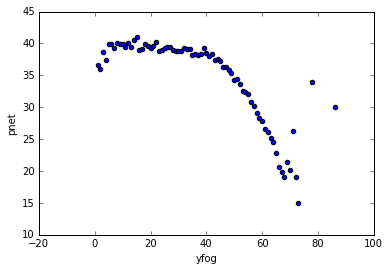

In [114]:
punts_dist.plot(kind='scatter', x='yfog', y='pnet')

## Code situations where the offense can take a knee(s) to win
Code a situation a 1 if the offense can kneel to end the game
based on time remaining, defensive timeouts remaining,
down, and score difference.

In [115]:
print('Coding kneel downs.')

joined['kneel_down'] = np.zeros(joined.shape[0])

joined.loc[(joined.timd == 0) & (joined.secs_left <= 120) & (joined.dwn == 1) &
       (joined.score_diff > 0), 'kneel_down'] = 1
joined.loc[(joined.timd == 1) & (joined.secs_left <= 84) & (joined.dwn == 1) &
       (joined.score_diff > 0), 'kneel_down'] = 1
joined.loc[(joined.timd == 2) & (joined.secs_left <= 48) & (joined.dwn == 1) &
       (df.score_diff > 0), 'kneel_down'] = 1

joined.loc[(joined.timd == 0) & (joined.secs_left <= 84) & (joined.dwn == 2) &
       (joined.score_diff > 0), 'kneel_down'] = 1
joined.loc[(joined.timd == 1) & (joined.secs_left <= 45) & (joined.dwn == 2) &
       (joined.score_diff > 0), 'kneel_down'] = 1

joined.loc[(joined.timd == 0) & (joined.secs_left <= 42) & (joined.dwn == 3) &
       (joined.score_diff > 0), 'kneel_down'] = 1

joined.loc[(joined.score_diff <= 0) | (joined.dwn == 4), 'kneel_down'] = 0

Coding kneel downs.


## Only rush & pass plays that were actually executed are eligible for computing first down success rates

In [116]:
df_plays = joined.loc[joined['type'].isin(['PASS', 'RUSH']), :].copy()

## Compute First Down Rates
Find the mean 1st down success rate at a given point in the field.

#### Parameters
----------
df_plays : DataFrame
yfog     : str, must be 'yfog' or 'yfog_bin'
           If yfog, use the actual yards from own goal
           If yfog_bin, use the decile of the field instead.

## Yfog bin for Open Field (< 90)

In [117]:
# Break the field into deciles
downs = df_plays.copy()
downs['yfog_bin'] = downs.yfog // 10
downs = downs.loc[downs.yfog_bin < 90].copy()
   
# For each segment, find the average first down rate by dwn & ytg
grouped = (downs.groupby(['yfog_bin', 'dwn', 'ytg'])['first_down']
                .agg({'fdr': np.mean, 'N': len})
                .reset_index())

# Just keep 3rd & 4th downs
grouped = grouped.loc[grouped.dwn >= 3].copy()
merged = grouped.merge(grouped, on=['yfog_bin', 'ytg'], how='left')

# Note this will lose scenarios that have *only* ever seen a 4th down
# This matches to one play since 2001.
merged = merged.loc[(merged.dwn_x == 4) & (merged.dwn_y == 3)].copy()

# Compute a weighted mean of FDR on 3rd & 4th down to deal with sparsity
merged['weighted_N_x'] = (merged.fdr_x * merged.N_x)
merged['weighted_N_y'] = (merged.fdr_y * merged.N_y)
merged['weighted_total'] = (merged.weighted_N_x + merged.weighted_N_y)
merged['total_N'] = (merged.N_x + merged.N_y)
merged['weighted_fdr'] = (merged.weighted_total / merged.total_N)
merged = merged.drop(labels=['weighted_N_x', 'weighted_N_y',
                             'weighted_total', 'total_N'], axis='columns')
merged = merged.rename(columns={'dwn_x': 'dwn'})

# Need to fill in any missing combinations where possible
merged = merged.set_index(['yfog_bin', 'dwn', 'ytg'])
p = pd.MultiIndex.from_product(merged.index.levels,
                               names=merged.index.names)
merged = merged.reindex(p, fill_value=None).reset_index()
merged = merged.rename(columns={'weighted_fdr': 'fdr'})

# Eliminate impossible combinations
# Sparse situations, just set to p(success) = 0.1
merged.loc[merged.ytg > 13, 'fdr'] = 0.10

# Missing values inside -10 because no one goes for it here
merged.loc[(merged.fdr_x.isnull()) & (merged.ytg <= 3),
           'fdr'] = .2
merged.loc[(merged.fdr_x.isnull()) & (merged.ytg > 3),
           'fdr'] = .1

# Fill in missing values
merged['fdr'] = merged['fdr'].interpolate()
fd_open_field = merged.copy()
fd_open_field.to_csv('data/fd_open_field.csv', index=False)

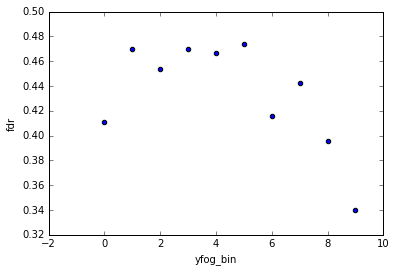

In [118]:
fd_open_field[(fd_open_field['dwn']==4.0)&
             (fd_open_field['ytg']==5.0)][['yfog_bin','fdr']].plot(kind='scatter', x='yfog_bin', y='fdr')

## Yfog for inside 10 yard line

In [119]:
#fd_inside_10 = first_down_rates(df_plays, 'yfog')
# For each segment, find the average first down rate by dwn & ytg
downs = df_plays.copy()
downs = downs.loc[downs.yfog >= 90].copy()
grouped = (downs.groupby(['yfog', 'dwn', 'ytg'])['first_down']
                .agg({'fdr': np.mean, 'N': len})
                .reset_index())

# Just keep 3rd & 4th downs
grouped = grouped.loc[grouped.dwn >= 3].copy()
merged = grouped.merge(grouped, on=['yfog', 'ytg'], how='left')

# Note this will lose scenarios that have *only* ever seen a 4th down
# This matches to one play since 2001.
merged = merged.loc[(merged.dwn_x == 4) & (merged.dwn_y == 3)].copy()

# Compute a weighted mean of FDR on 3rd & 4th down to deal with sparsity
merged['weighted_N_x'] = (merged.fdr_x * merged.N_x)
merged['weighted_N_y'] = (merged.fdr_y * merged.N_y)
merged['weighted_total'] = (merged.weighted_N_x + merged.weighted_N_y)
merged['total_N'] = (merged.N_x + merged.N_y)
merged['weighted_fdr'] = (merged.weighted_total / merged.total_N)
merged = merged.drop(labels=['weighted_N_x', 'weighted_N_y',
                             'weighted_total', 'total_N'], axis='columns')
merged = merged.rename(columns={'dwn_x': 'dwn'})

# Need to fill in any missing combinations where possible
merged = merged.set_index(['yfog', 'dwn', 'ytg'])
p = pd.MultiIndex.from_product(merged.index.levels,
                               names=merged.index.names)
merged = merged.reindex(p, fill_value=None).reset_index()
merged = merged.rename(columns={'weighted_fdr': 'fdr'})

merged = merged.loc[(merged.yfog + merged.ytg <= 100)]
merged.loc[(merged.yfog == 99) & (merged.ytg == 1), 'fdr'] = (
        merged.loc[(merged.yfog == 99) & (merged.ytg == 1), 'fdr_x'])
merged['fdr'] = merged['fdr'].interpolate()
merged.to_csv('data/fd_inside_10.csv', index=False)

fd_inside_10 = merged.copy()

In [120]:
fd_inside_10.head()

,yfog,dwn,ytg,fdr_x,N_x,dwn_y,fdr_y,N_y,fdr
0,90.0,4.0,1.0,0.882353,34.0,3.0,0.659341,91.0,0.720000
1,90.0,4.0,2.0,0.500000,6.0,3.0,0.521739,69.0,0.520000
2,90.0,4.0,3.0,0.625000,8.0,3.0,0.422535,71.0,0.443038
3,90.0,4.0,4.0,0.166667,6.0,3.0,0.343284,67.0,0.328767
4,90.0,4.0,5.0,0.600000,5.0,3.0,0.413333,75.0,0.425000


## Join first down rates
Join the computed first down rates with the play by play data.

In [121]:
joined = join_df_first_down_rates(joined, fd_open_field, fd_inside_10)

## Calculate final drive statistics
Determine the starting point for the final possession in each
non-overtime, regular season game to use as a proxy for the probability
that the team will have another possession in the game during the
4th quarter.

Used to weight the win probabilities in the 4th quarter.

In [122]:
print('Calculating final drive statistics.')

drives = pd.read_csv( '{}/DRIVE.csv'.format('csv'), index_col=1)
drives = drives.merge(games[['seas', 'wk']],
                      left_index=True, right_index=True)

# Restrict to non-overtime games

final_qtr = drives.reset_index().groupby('gid')[['qtr']].max()
overtime_games = final_qtr[final_qtr.qtr > 4].index
drives_reduced = drives[-drives.index.isin(overtime_games)].copy()

# Starting time of final drive of game

drives_reduced = drives_reduced.loc[drives_reduced.qtr == 4]
final_drive = drives_reduced.reset_index().groupby('gid').last()
final_drive['secs'] = (final_drive['min'] * 60) + final_drive.sec

# Group and get summary statistics
final_drives = (final_drive.groupby('secs')['fpid']
                           .agg({'n': len})
                           .reset_index())

final_drives['pct'] = final_drives.n / final_drives.n.sum()
final_drives['cum_pct'] = final_drives.pct.cumsum()

final_drives.to_csv('data/final_drives.csv')

Calculating final drive statistics.


## Write cleaned data to file

In [123]:
print('Writing cleaned play-by-play data.')
joined.to_csv('data/pbp_cleaned.csv')

Writing cleaned play-by-play data.


## Only train on actual plays, remove 2pt conversion attempts

In [124]:
print('Reading play by play data.')
df = pd.read_csv('data/pbp_cleaned.csv', index_col=0)
df_plays = df.loc[(df['type'] != 'CONV')].copy()

Reading play by play data.


# Custom features
## Interaction between qtr & score difference -- late score differences are more important than early ones.

In [125]:
df_plays['qtr_scorediff'] = df_plays.qtr * df_plays.score_diff

## Decay effect of spread over course of game

In [126]:
df_plays['spread'] = df_plays.spread * (df_plays.secs_left / 3600)

## Features to use in the model

In [127]:
features = ['dwn', 'yfog', 'secs_left',
            'score_diff', 'timo', 'timd', 'spread',
            'kneel_down', 'qtr',
            'qtr_scorediff']
target = 'win'

## Splitting data into train/test sets.

In [128]:
print('Splitting data into train/test sets.')
(train_X, test_X, train_y, test_y) = train_test_split(df_plays[features],
                                                  df_plays[target],
                                                  test_size=0.1)

Splitting data into train/test sets.


## Scaling features

In [129]:
print('Scaling features.')
scaler = StandardScaler()
scaler.fit(train_X)
train_X_scaled = scaler.transform(train_X)

Scaling features.


## Training model

In [130]:
print('Training model.')
logit = LogisticRegression()
logit.fit(train_X_scaled, train_y)

Training model.


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)

## Making predictions on test set

In [131]:
print('Making predictions on test set.')
test_X_scaled = scaler.transform(test_X)
preds = logit.predict_proba(test_X_scaled)[:, 1]

Making predictions on test set.


## Evaluating model performance

In [132]:
print('Evaluating model performance.')
fpr, tpr, thresholds = roc_curve(test_y, preds)
roc_auc = auc(fpr, tpr)
print('AUC: {}'.format(roc_auc))
print('Log loss: {}'.format(log_loss(test_y, preds)))
pred_outcomes = logit.predict(test_X_scaled)
print(classification_report(test_y, pred_outcomes))
print('F1 score: {}'.format(f1_score(test_y, pred_outcomes)))

Evaluating model performance.
AUC: 0.862048348699
Log loss: 0.456478047836
             precision    recall  f1-score   support

          0       0.77      0.77      0.77     27776
          1       0.78      0.77      0.78     28327

avg / total       0.77      0.77      0.77     56103

F1 score: 0.77524372335


## Plot ROC Curve and Calibration Plot

In [133]:
def calibration_plot(preds, truth):
    """Produces a calibration plot for the win probability model.

    Splits the predictions into percentiles and calculates the
    percentage of predictions per percentile that were wins. A perfectly
    calibrated model means that plays with a win probability of n%
    win about n% of the time.
    """
    cal_df = pd.DataFrame({'pred': preds, 'win': truth})
    cal_df['pred_bin'] = pd.cut(cal_df.pred, 100, labels=False)

    win_means = cal_df.groupby('pred_bin')['win'].mean()

    plt.figure()
    plt.plot(win_means.index.values,
             [100 * v for v in win_means.values], color='SteelBlue')
    plt.plot(np.arange(0, 100), np.arange(0, 100), 'k--', alpha=0.3)
    plt.xlim([0.0, 100])
    plt.ylim([0.0, 100])
    plt.xlabel('Estimated win probability')
    plt.ylabel('True win percentage')
    plt.title('Win probability calibration, binned by percent')

    return

In [134]:
def plot_roc(fpr, tpr, roc_auc):
    """Plots the ROC curve for the win probability model along with
    the AUC.
    """
    fig, ax = plt.subplots()
    ax.set(title='Receiver Operating Characteristic',
           xlim=[0, 1], ylim=[0, 1], xlabel='False Positive Rate',
           ylabel='True Positive Rate')
    ax.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.legend(loc='lower right')

Plotting ROC curve and calibration plot.
Note: plots may appear behind current active window.


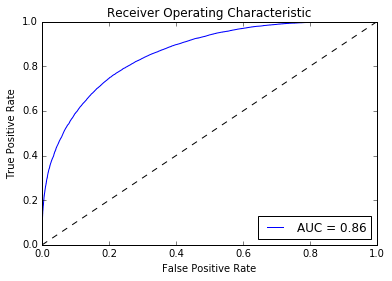

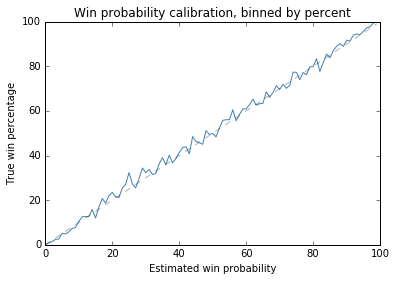

In [135]:
print('Plotting ROC curve and calibration plot.')
print('Note: plots may appear behind current active window.')
plot_roc(fpr, tpr, roc_auc)
calibration_plot(preds, test_y)

## Pickling (save) model and scaler

In [136]:
print('Pickling model and scaler.')
if not os.path.exists('models'):
    os.mkdir('models')
    
joblib.dump(logit, 'models/win_probability.pkl')
joblib.dump(scaler, 'models/scaler.pkl')

Pickling model and scaler.


['models/scaler.pkl', 'models/scaler.pkl_01.npy', 'models/scaler.pkl_02.npy']

In [137]:
def load_data():
    data = {}
    data['fgs'] = pd.read_csv('data/fgs_grouped.csv')
    data['punts'] = pd.read_csv('data/punts_grouped.csv')
    data['fd_open_field'] = pd.read_csv('data/fd_open_field.csv')
    data['fd_inside_10'] = pd.read_csv('data/fd_inside_10.csv')
    data['final_drives'] = pd.read_csv('data/final_drives.csv')
    data['decisions'] = pd.read_csv('data/coaches_decisions.csv')
    data['scaler'] = joblib.load('models/scaler.pkl')
    data['features'] = ['dwn', 'yfog', 'secs_left',
                        'score_diff', 'timo', 'timd', 'spread',
                        'kneel_down', 'qtr', 'qtr_scorediff']

    model = joblib.load('models/win_probability.pkl')
    return data, model

In [138]:
def kneel_down(score_diff, timd, secs_left, dwn):
    """Return 1 if the offense can definitely kneel out the game,
    else return 0."""

    if score_diff <= 0 or dwn == 4:
        return 0

    if timd == 0 and secs_left <= 120 and dwn == 1:
        return 1
    if timd == 1 and secs_left <= 87 and dwn == 1:
        return 1
    if timd == 2 and secs_left <= 48 and dwn == 1:
        return 1

    if timd == 0 and secs_left <= 84 and dwn == 2:
        return 1
    if timd == 1 and secs_left <= 45 and dwn == 2:
        return 1

    if timd == 0 and secs_left <= 42 and dwn == 3:
        return 1

    return 0

def change_poss(situation, play_type, features, **kwargs):
    """Handles situation updating for all plays that involve
    a change of possession, including punts, field goals,
    missed field goals, touchdowns, turnover on downs.
    Parameters
    ----------
    situation : OrderedDict
    play_type : function
    features  : list[str]
    Returns
    -------
    new_situation : OrderedDict
    """

    new_situation = OrderedDict.fromkeys(features)

    # Nearly all changes of possession result in a 1st & 10
    # Doesn't cover the edge case of a turnover within own 10 yardline.
    new_situation['dwn'] = 1
    new_situation['ytg'] = 10

    # Assumes 10 seconds of game clock have elapsed per play
    # Could tune this.
    new_situation['secs_left'] = max([situation['secs_left'] - 10, 0])
    new_situation['qtr'] = qtr(new_situation['secs_left'])

    # Assign timeouts to the correct teams
    new_situation['timo'], new_situation['timd'] = (
            situation['timd'], situation['timo'])

    # Valid types are turnover_downs, punt, field_goal,
    # missed_field_goal, touchdown

    # Any score changes are handled here
    new_situation = play_type(situation, new_situation, **kwargs)

    # Change sign on spread, recompute over-under
    new_situation['spread'] = -1 * situation['spread'] + 0

    # Avoid negative zeros
    if new_situation.get('score_diff') is None:
        new_situation['score_diff'] = int(-1 * situation['score_diff'])
    else:
        new_situation['score_diff'] = int(-1 * new_situation['score_diff'])

    new_situation['kneel_down'] = kneel_down(new_situation['score_diff'],
                                             new_situation['timd'],
                                             new_situation['secs_left'],
                                             new_situation['dwn'])

    new_situation['qtr_scorediff'] = (
            new_situation['qtr'] * new_situation['score_diff'])

    return new_situation


def field_goal(situation, new_situation, **kwargs):
    new_situation['score_diff'] = situation['score_diff'] + 3

    # Assume the starting field position will be own 25, accounts
    # for touchbacks and some run backs.

    new_situation['yfog'] = 25

    return new_situation


def missed_field_goal(situation, new_situation, **kwargs):
    """Opponent takes over from the spot of the kick."""
    new_situation['yfog'] = 100 - (situation['yfog'] - 8)
    return new_situation


def touchdown(situation, new_situation, **kwargs):
    """Assumes successful XP and no 2PC -- revisit this for 2015?"""
    new_situation['score_diff'] = situation['score_diff'] + 7
    new_situation['yfog'] = 25
    return new_situation


def turnover_downs(situation, new_situation, **kwargs):
    new_situation['yfog'] = 100 - situation['yfog']
    return new_situation


def punt(situation, new_situation, **kwargs):
    """Use the average net punt distance (punt distance - return yards).
    Not all situations have historical data, especially very
    close to opponent's end zone. Use a net punt distance of
    5 yards here.
    """

    default_punt = 5

    try:
        pnet = kwargs['data'].loc[kwargs['data'].yfog == situation['yfog'],
                                  'pnet'].values[0]

    except IndexError:
        pnet = default_punt

    new_yfog = np.floor(100 - (situation['yfog'] + pnet))

    # Touchback
    new_situation['yfog'] = new_yfog if new_yfog > 0 else 25

    return new_situation


def first_down(situation):
    new_situation = OrderedDict()
    new_situation['dwn'] = 1

    yfog = situation['yfog'] + situation['ytg']
    new_situation['ytg'] = min([10, yfog])
    new_situation['yfog'] = yfog

    # 10 seconds of clock time elapsed, or game over.
    new_situation['secs_left'] = max([situation['secs_left'] - 10, 0])

    # These values don't change
    new_situation['score_diff'] = situation['score_diff']
    new_situation['timo'], new_situation['timd'] = (
            situation['timo'], situation['timd'])
    new_situation['spread'] = situation['spread']

    new_situation['kneel_down'] = kneel_down(new_situation['score_diff'],
                                             new_situation['timd'],
                                             new_situation['secs_left'],
                                             new_situation['dwn'])

    new_situation['qtr'] = qtr(new_situation['secs_left'])
    new_situation['qtr_scorediff'] = (
            new_situation['qtr'] * new_situation['score_diff'])

    return new_situation


def qtr(secs_left):
    if secs_left <= 900:
        return 4
    if secs_left <= 1800:
        return 3
    if secs_left <= 2700:
        return 2
    return 1

def generate_response(situation, data, model):
    """Parent function called by the bot to make decisions on 4th downs.

    Parameters
    ----------
    situation : OrderedDict
    data      : dict, contains historical data
    model     : LogisticRegression

    Returns
    -------
    payload   : dict
    """

    situation = calculate_features(situation, data)

    # Generate the game state of possible outcomes
    scenarios = simulate_scenarios(situation, data)

    # Calculate the win probability for each scenario
    probs = generate_win_probabilities(situation, scenarios, model, data)

    # Calculate breakeven points, make decision on optimal decision
    decision, probs = generate_decision(situation, data, probs)

    payload = {'decision': decision, 'probs': probs, 'situation': situation}

    return payload


def calculate_features(situation, data):
    """Generate features needed for the win probability model that are
    not contained in the general game state information passed via API.

    Parameters
    ----------
    situation : OrderedDict

    Returns
    -------
    situation : The same OrderedDict, with new keys and values.
    """

    situation['kneel_down'] = kneel_down(situation['score_diff'],
                                           situation['timd'],
                                           situation['secs_left'],
                                           situation['dwn'])

    situation['qtr'] = qtr(situation['secs_left'])
    situation['qtr_scorediff'] = situation['qtr'] * situation['score_diff']

    situation['spread'] = (
            situation['spread'] * (situation['secs_left'] / 3600))

    cum_pct = (
        (situation['secs_left'] - data['final_drives'].secs).abs().argmin())

    situation['poss_prob'] = data['final_drives'].ix[cum_pct].cum_pct

    return situation


def qtr(secs_left):
    """Given the seconds left in the game, determine the current quarter."""
    if secs_left <= 900:
        return 4
    if secs_left <= 1800:
        return 3
    if secs_left <= 2700:
        return 2
    return 1


def simulate_scenarios(situation, data):
    """Simulate game state after each possible outcome.

    Possible scenarios are: touchdown, first down, turnover on downs,
    field goal attempt (success or failure), and punt.
    """

    features = data['features']
    scenarios = dict()

    # If it's 4th & goal, success is a touchdown, otherwise a 1st down.

    if situation['ytg'] + situation['yfog'] >= 100:
        scenarios['touchdown'] = change_poss(situation, touchdown, features)
    else:
        scenarios['first_down'] = first_down(situation)

    scenarios['fail'] = change_poss(situation, turnover_downs, features)

    scenarios['punt'] = change_poss(situation, punt, features,
                                      data=data['punts'])

    scenarios['fg'] = change_poss(situation, field_goal, features)
    scenarios['missed_fg'] = change_poss(situation, missed_field_goal,
                                           features)

    return scenarios


def generate_win_probabilities(situation, scenarios, model, data, **kwargs):
    """For each of the possible scenarios, estimate the win probability
    for that game state."""

    probs = dict.fromkeys([k + '_wp' for k in scenarios.keys()])

    features = data['features']

    # Pre-play win probability calculation
    # Note there is more information in situation than just model features.

    feature_vec = [val for key, val in situation.items() if key in features]
    feature_vec = data['scaler'].transform(feature_vec)

    probs['pre_play_wp'] = model.predict_proba(feature_vec)[0][1]

    for scenario, outcome in scenarios.items():
        feature_vec = [val for key, val in outcome.items() if key in features]
        feature_vec = data['scaler'].transform(feature_vec)
        pred_prob = model.predict_proba(feature_vec)[0][1]

        # Change of possessions require 1 - WP
        if scenario in ('fg', 'fail', 'punt', 'missed_fg', 'touchdown'):
            pred_prob = 1 - pred_prob

        probs[str(scenario + '_wp')] = pred_prob

    # Account for situations in which an opponent's field goal can end
    # the game, driving win probability down to 0.

    if (situation['secs_left'] < 40 and (0 <= situation['score_diff'] <= 2)
            and situation['timo'] == 0):
        # Estimate probability of successful field goal and
        # set the win probability of failing to convert a 4th down
        # to that win probability.

        if situation['dome'] > 0:
            prob_opp_fg = (data['fgs'].loc[
                    data['fgs'].yfog == scenarios['fail']['yfog'],
                    'average'].values[0])
        else:
            prob_opp_fg = (data['fgs'].loc[
                    data['fgs'].yfog == scenarios['fail']['yfog'],
                    'average'].values[0])

        probs['fail_wp'] = ((1 - prob_opp_fg) * probs['fail_wp'])

    # Teams may not get the ball back during the 4th quarter

    if situation['qtr'] == 4:
        probs['fail_wp'] = probs['fail_wp'] * situation['poss_prob']
        probs['punt_wp'] = probs['punt_wp'] * situation['poss_prob']

    # Always have a 'success_wp' field, regardless of TD or 1st down

    if 'touchdown_wp' in probs:
        probs['success_wp'] = probs['touchdown_wp']
    else:
        probs['success_wp'] = probs['first_down_wp']
    return probs


def generate_decision(situation, data, probs, **kwargs):
    """Decide on optimal play based on game states and their associated
    win probabilities. Note the currently 'best play' is based purely
    on the outcome with the highest expected win probability. This
    does not account for uncertainty of these estimates.

    For example, the win probabilty added by a certain play may be
    very small (0.0001), but that may be the 'best play.'
    """

    decision = {}

    decision['prob_success'] = calc_prob_success(situation, data)

    # Expected value of win probability of going for it
    wp_ev_goforit = expected_win_prob(decision['prob_success'],
                                      probs['success_wp'],
                                      probs['fail_wp'])
    probs['wp_ev_goforit'] = wp_ev_goforit

    # Expected value of kick factors in probability of FG
    probs['prob_success_fg'], probs['fg_ev_wp'] = expected_wp_fg(
            situation, probs, data)

    # If the offense can end the game with a field goal, set the
    # expected win probability for a field goal attempt to the
    # probability of a successful field goal kick.

    if (situation['secs_left'] < 40 and (-2 <= situation['score_diff'] <= 0)
        and situation['timd'] == 0):
            probs['fg_wp'] = probs['prob_success_fg']
            probs['fg_ev_wp'] = probs['prob_success_fg']

    # If down by more than a field goal in the 4th quarter, need to
    # incorporate the probability that you will get the ball back.

    if situation['qtr'] == 4 and situation['score_diff'] < -3:
        probs['fg_ev_wp'] = probs['fg_ev_wp'] * situation['poss_prob']

    # Breakeven success probabilities
    decision['breakeven_punt'], decision['breakeven_fg'] = breakeven(probs)

    # Of the kicking options, pick the one with the highest E(WP)
    decision['kicking_option'], decision['wpa_going_for_it'] = (
            best_kicking_option(probs, wp_ev_goforit))

    # Make the final call on kick / punt / go for it
    # If a win is unlikely in any circumstance, favor going for it.

    # if probs['pre_play_wp'] < .05:
    #     decision['best_play'] = 'go for it'
    # else:
    decision['best_play'] = decide_best_play(decision)

    # Only provide historical data outside of two-minute warning
    decision = get_historical_decision(situation, data, decision)

    return decision, probs


def get_historical_decision(situation, data, decision):
    """Compare current game situation to historically similar situations.

    Currently uses score difference and field position to provide
    rough guides to what coaches have done in the past.
    """

    historical_data = data['decisions']

    down_by_td = situation['score_diff'] <= -4
    up_by_td = situation['score_diff'] >= 4
    yfog_bin = situation['yfog'] // 20
    short_tg = int(situation['ytg'] <= 3)
    med_tg = int((situation['ytg'] >= 4) and (situation['ytg'] <= 7))
    long_tg = int(situation['ytg'] > 7)

    history = historical_data.loc[(historical_data.down_by_td == down_by_td) &
                                  (historical_data.up_by_td == up_by_td) &
                                  (historical_data.yfog_bin == yfog_bin) &
                                  (historical_data.short == short_tg) &
                                  (historical_data.med == med_tg) &
                                  (historical_data['long'] == long_tg)]

    # Check to see if no similar situations
    if historical_data.shape[0] == 0:
        decision['historical_goforit_pct'] = 'None'
        decision['historical_punt_pct'] = 'None'
        decision['historical_kick_pct'] = 'None'
        decision['historical_N'] = 'None'
    else:
        decision['historical_punt_pct'] = (history.proportion_punted.values[0])
        decision['historical_kick_pct'] = (history.proportion_kicked.values[0])
        decision['historical_goforit_pct'] = (history.proportion_went.values[0])
        decision['historical_goforit_N'] = (history.sample_size.values[0])
    return decision


def expected_win_prob(pos_prob, pos_win_prob, neg_win_prob):
    """Expected value of win probability, factoring in p(success)."""
    return (pos_prob * pos_win_prob) + ((1 - pos_prob) * neg_win_prob)


def expected_wp_fg(situation, probs, data):
    """Expected WP from kicking, factoring in p(FG made)."""
    if 'fg_make_prob' in situation and isinstance(situation['fg_make_prob'], float):
        pos = situation['fg_make_prob']
    else:
        fgs = data['fgs']

        # Set the probability of success of implausibly long kicks to 0.
        if situation['yfog'] < 42:
            pos = 0
        else:
            # Account for indoor vs. outdoor kicking
            if situation['dome'] > 0:
                pos = fgs.loc[fgs.yfog == situation['yfog'], 'average'].values[0]
            else:
                pos = fgs.loc[fgs.yfog == situation['yfog'], 'average'].values[0]

    return pos, expected_win_prob(pos, probs['fg_wp'], probs['missed_fg_wp'])
    return pos, expected_win_prob(pos, probs['fg_wp'], probs['missed_fg_wp'])


def breakeven(probs):
    """Calculates the breakeven point for making the decision.

    The breakeven is the point at which a coach should be indifferent
    between two options. We compare the expected win probability
    of going for it on 4th down to the next best kicking option
    and determine what the probability of converting the 4th down
    needs to be in order to make the coach indifferent to going for it
    or kicking.
    """

    denom = probs['success_wp'] - probs['fail_wp']

    breakeven_punt = (probs['punt_wp'] - probs['fail_wp']) / denom
    breakeven_fg = (probs['fg_ev_wp'] - probs['fail_wp']) / denom

    # Coerce breakevens to be in the range [0, 1]
    breakeven_punt = max(min(1, breakeven_punt), 0)
    breakeven_fg = max(min(1, breakeven_fg), 0)

    return breakeven_punt, breakeven_fg


def calc_prob_success(situation, data):
    """Use historical first down rates. When inside the opponent's 10,
    use dwn, ytg, yfog specific rates. Otherwise, use binned yfog where
    field is broken into 10 segments"""

    fd_open = data['fd_open_field']
    fd_inside = data['fd_inside_10']

    if situation['yfog'] < 90:
        try:
            yfog_bin = situation['yfog'] // 10
            p_success = fd_open.loc[(fd_open.dwn == situation['dwn']) &
                                    (fd_open.ytg == situation['ytg']) &
                                    (fd_open.yfog_bin == yfog_bin),
                                    'fdr'].values[0]
        except IndexError:
            # Arbitrary, set the probability of success for very long
            # 4th downs to be 0.1
            p_success = 0.1

    else:
        p_success = fd_inside.loc[(fd_inside.dwn == situation['dwn']) &
                                  (fd_inside.ytg == situation['ytg']) &
                                  (fd_inside.yfog == situation['yfog']),
                                  'fdr'].values[0]
    return p_success


def best_kicking_option(probs, wp_ev_goforit):
    """Use the expected win probabilities to determine best kicking option"""

    # Account for end of game situations where FG WP is higher
    if probs['fg_ev_wp'] > probs['punt_wp'] and probs['prob_success_fg'] > .3:
        decision = 'kick'
        win_prob_added = wp_ev_goforit - probs['fg_ev_wp']

    else:
        decision = 'punt'
        win_prob_added = wp_ev_goforit - probs['punt_wp']

    return decision, win_prob_added


def decide_best_play(decision):
    if (decision['kicking_option'] == 'punt' and
            decision['prob_success'] < decision['breakeven_punt']):
        return 'punt'

    elif (decision['kicking_option'] == 'kick' and
            decision['prob_success'] < decision['breakeven_fg']):
        return 'kick'

    else:
        return 'go for it'


def random_play(data):
    """Generate a random play with plausible values for debugging purposes."""

    features = data['features']
    situation = OrderedDict.fromkeys(features)

    situation['dwn'] = 4
    situation['ytg'] = random.randint(1, 10)
    situation['yfog'] = random.randint(1, (100 - situation['ytg']))
    situation['secs_left'] = random.randint(1, 3600)
    situation['score_diff'] = random.randint(-20, 20)
    situation['timo'] = random.randint(0, 3)
    situation['timd'] = random.randint(0, 3)
    situation['spread'] = 0

    situation = calculate_features(situation, data)

    situation['dome'] = random.randint(0, 1)
    return situation


# Generating Response

In [139]:
data, model = load_data()

In [140]:
situation = random_play(data)

In [141]:
situation

OrderedDict([('dwn', 4), ('yfog', 50), ('secs_left', 524), ('score_diff', -17), ('timo', 0), ('timd', 2), ('spread', 0.0), ('kneel_down', 0), ('qtr', 4), ('qtr_scorediff', -68), ('ytg', 1), ('poss_prob', 0.99749023982199991), ('dome', 1)])

In [142]:
situation = calculate_features(situation, data)

## Simulate Scenarios
Simulate game state after each possible outcome.

Possible scenarios are: touchdown, first down, turnover on downs,
field goal attempt (success or failure), and punt.

In [143]:
features = data['features']
scenarios = dict()

# If it's 4th & goal, success is a touchdown, otherwise a 1st down.

if situation['ytg'] + situation['yfog'] >= 100:
    scenarios['touchdown'] = change_poss(situation, touchdown, features)
else:
    scenarios['first_down'] = first_down(situation)

scenarios['fail'] = change_poss(situation, turnover_downs, features)

scenarios['punt'] = change_poss(situation, punt, features,
                                  data=data['punts'])

scenarios['fg'] = change_poss(situation, field_goal, features)
scenarios['missed_fg'] = change_poss(situation, missed_field_goal,
                                       features)


In [144]:
scenarios

{'fail': OrderedDict([('dwn', 1), ('yfog', 50), ('secs_left', 514), ('score_diff', 17), ('timo', 2), ('timd', 0), ('spread', 0.0), ('kneel_down', 0), ('qtr', 4), ('qtr_scorediff', 68), ('ytg', 10)]),
 'fg': OrderedDict([('dwn', 1), ('yfog', 25), ('secs_left', 514), ('score_diff', 14), ('timo', 2), ('timd', 0), ('spread', 0.0), ('kneel_down', 0), ('qtr', 4), ('qtr_scorediff', 56), ('ytg', 10)]),
 'first_down': OrderedDict([('dwn', 1), ('ytg', 10), ('yfog', 51), ('secs_left', 514), ('score_diff', -17), ('timo', 0), ('timd', 2), ('spread', 0.0), ('kneel_down', 0), ('qtr', 4), ('qtr_scorediff', -68)]),
 'missed_fg': OrderedDict([('dwn', 1), ('yfog', 58), ('secs_left', 514), ('score_diff', 17), ('timo', 2), ('timd', 0), ('spread', 0.0), ('kneel_down', 0), ('qtr', 4), ('qtr_scorediff', 68), ('ytg', 10)]),
 'punt': OrderedDict([('dwn', 1), ('yfog', 15.0), ('secs_left', 514), ('score_diff', 17), ('timo', 2), ('timd', 0), ('spread', 0.0), ('kneel_down', 0), ('qtr', 4), ('qtr_scorediff', 68), ('

## Generate Win Probabilities
For each of the possible scenarios, estimate the win probability
for that game state.

In [145]:
probs = dict.fromkeys([k + '_wp' for k in scenarios.keys()])

features = data['features']

####  Pre-play win probability calculation
 Note there is more information in situation than just model features.

In [147]:
feature_vec = [val for key, val in situation.items() if key in features]
feature_vec = data['scaler'].transform(feature_vec)

probs['pre_play_wp'] = model.predict_proba(feature_vec)[0][1]

for scenario, outcome in scenarios.items():
    feature_vec = [val for key, val in outcome.items() if key in features]
    feature_vec = data['scaler'].transform(feature_vec)
    pred_prob = model.predict_proba(feature_vec)[0][1]

    # Change of possessions require 1 - WP
    if scenario in ('fg', 'fail', 'punt', 'missed_fg', 'touchdown'):
        pred_prob = 1 - pred_prob

    probs[str(scenario + '_wp')] = pred_prob

#### Account for situations in which an opponent's field goal can end the game, driving win probability down to 0.

In [148]:
if (situation['secs_left'] < 40 and (0 <= situation['score_diff'] <= 2)
        and situation['timo'] == 0):
    # Estimate probability of successful field goal and
    # set the win probability of failing to convert a 4th down
    # to that win probability.

    if situation['dome'] > 0:
        prob_opp_fg = (data['fgs'].loc[
                data['fgs'].yfog == scenarios['fail']['yfog'],
                'dome_rate'].values[0])
    else:
        prob_opp_fg = (data['fgs'].loc[
                data['fgs'].yfog == scenarios['fail']['yfog'],
                'open_rate'].values[0])

    probs['fail_wp'] = ((1 - prob_opp_fg) * probs['fail_wp'])

#### Teams may not get the ball back during the 4th quarter
#### Always have a 'success_wp' field, regardless of TD or 1st down

In [149]:
if situation['qtr'] == 4:
    probs['fail_wp'] = probs['fail_wp'] * situation['poss_prob']
    probs['punt_wp'] = probs['punt_wp'] * situation['poss_prob']

if 'touchdown_wp' in probs:
    probs['success_wp'] = probs['touchdown_wp']
else:
    probs['success_wp'] = probs['first_down_wp']

In [150]:
probs

{'fail_wp': 0.012762516771399899,
 'fg_wp': 0.031548003762246646,
 'first_down_wp': 0.026590075584244782,
 'missed_fg_wp': 0.011881806482152646,
 'pre_play_wp': 0.020364559569521816,
 'punt_wp': 0.017626940900797982,
 'success_wp': 0.026590075584244782}

([<matplotlib.axis.XTick at 0x13402978>,
 <a list of 7 Text xticklabel objects>)

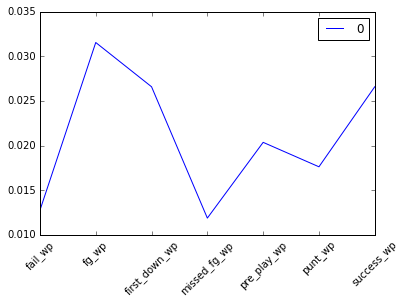

In [151]:
df = pd.DataFrame(probs, index=[0]).T
df.plot()
plt.xticks(np.arange(0, len(df.index), 1), df.index, rotation=45)

### Generate Decision
Decide on optimal play based on game states and their associated
win probabilities. Note the currently 'best play' is based purely
on the outcome with the highest expected win probability. This
does not account for uncertainty of these estimates.

For example, the win probabilty added by a certain play may be
very small (0.0001), but that may be the 'best play.

#### Calcluate Probability of Success
Use historical first down rates. When inside the opponent's 10,
use dwn, ytg, yfog specific rates. Otherwise, use binned yfog where
field is broken into 10 segments

In [152]:
decision = {}
decision['prob_success'] = calc_prob_success(situation, data)

#### Expected value of win probability of going for it

In [153]:
wp_ev_goforit = expected_win_prob(decision['prob_success'],
                                  probs['success_wp'],
                                  probs['fail_wp'])
probs['wp_ev_goforit'] = wp_ev_goforit

#### Expected value of kick factors in probability of FG

In [154]:
if 'fg_make_prob' in situation and isinstance(situation['fg_make_prob'], float):
    pos = situation['fg_make_prob']
else:
    fgs = data['fgs']

    # Set the probability of success of implausibly long kicks to 0.
    try:
        if situation['yfog'] < 42:
            pos = 0
        else:
            # Account for indoor vs. outdoor kicking
            if situation['dome'] > 0:
                pos = fgs.loc[fgs.yfog == situation['yfog'], 'average'].values[0]
            else:
                pos = fgs.loc[fgs.yfog == situation['yfog'], 'average'].values[0]

    except:
        pos = 0
            
probs['prob_success_fg']  = pos
probs['fg_ev_wp'] = expected_win_prob(pos, probs['fg_wp'], probs['missed_fg_wp'])

#### If the offense can end the game with a field goal, set the expected win probability for a field goal attempt to the probability of a successful field goal kick.

In [155]:
if (situation['secs_left'] < 40 and (-2 <= situation['score_diff'] <= 0)
    and situation['timd'] == 0):
        probs['fg_wp'] = probs['prob_success_fg']
        probs['fg_ev_wp'] = probs['prob_success_fg']

#### If down by more than a field goal in the 4th quarter, need to incorporate the probability that you will get the ball back.

In [156]:
if situation['qtr'] == 4 and situation['score_diff'] < -3:
    probs['fg_ev_wp'] = probs['fg_ev_wp'] * situation['poss_prob']

#### Breakeven success probabilities
##### Calculates the breakeven point for making the decision.
The breakeven is the point at which a coach should be indifferent
between two options. We compare the expected win probability
of going for it on 4th down to the next best kicking option
and determine what the probability of converting the 4th down
needs to be in order to make the coach indifferent to going for it
or kicking.

In [157]:
denom = probs['success_wp'] - probs['fail_wp']

breakeven_punt = (probs['punt_wp'] - probs['fail_wp']) / denom
breakeven_fg = (probs['fg_ev_wp'] - probs['fail_wp']) / denom

# Coerce breakevens to be in the range [0, 1]
breakeven_punt = max(min(1, breakeven_punt), 0)
breakeven_fg = max(min(1, breakeven_fg), 0)

decision['breakeven_fg'] = breakeven_fg
decision['breakeven_punt'] = breakeven_punt

#### Of the kicking options, pick the one with the highest E(WP)
Use the expected win probabilities to determine best kicking option

In [159]:
# Account for end of game situations where FG WP is higher
if probs['fg_ev_wp'] > probs['punt_wp'] and probs['prob_success_fg'] > .3:
    kick_decision = 'kick'
    win_prob_added = wp_ev_goforit - probs['fg_ev_wp']

else:
    kick_decision = 'punt'
    win_prob_added = wp_ev_goforit - probs['punt_wp']

decision['kicking_option'] = kick_decision
decision['wpa_going_for_it'] = win_prob_added

#### Make the final call on kick / punt / go for it

In [160]:
if (decision['kicking_option'] == 'punt' and
        decision['prob_success'] < decision['breakeven_punt']):
    best_play = 'punt'

elif (decision['kicking_option'] == 'kick' and
        decision['prob_success'] < decision['breakeven_fg']):
    best_play = 'kick'

else:
    best_play = 'go for it'
    
decision['best_play'] = best_play

In [161]:
decision

{'best_play': 'go for it',
 'breakeven_fg': 0,
 'breakeven_punt': 0.35179196814403396,
 'kicking_option': 'punt',
 'prob_success': 0.68804664723000009,
 'wpa_going_for_it': 0.0046495813511554795}

In [162]:
probs

{'fail_wp': 0.012762516771399899,
 'fg_ev_wp': 0.011851985997401036,
 'fg_wp': 0.031548003762246646,
 'first_down_wp': 0.026590075584244782,
 'missed_fg_wp': 0.011881806482152646,
 'pre_play_wp': 0.020364559569521816,
 'prob_success_fg': 0,
 'punt_wp': 0.017626940900797982,
 'success_wp': 0.026590075584244782,
 'wp_ev_goforit': 0.022276522251953462}

## Compare to Historical Decision

In [163]:
decision = get_historical_decision(situation, data, decision)

In [164]:
payload = {'decision': decision, 'probs': probs, 'situation': situation}

In [165]:
payload

{'decision': {'best_play': 'go for it',
  'breakeven_fg': 0,
  'breakeven_punt': 0.35179196814403396,
  'historical_goforit_N': 1412.0,
  'historical_goforit_pct': 0.41855524079299999,
  'historical_kick_pct': 0.00070821529745000006,
  'historical_punt_pct': 0.58073654390899998,
  'kicking_option': 'punt',
  'prob_success': 0.68804664723000009,
  'wpa_going_for_it': 0.0046495813511554795},
 'probs': {'fail_wp': 0.012762516771399899,
  'fg_ev_wp': 0.011851985997401036,
  'fg_wp': 0.031548003762246646,
  'first_down_wp': 0.026590075584244782,
  'missed_fg_wp': 0.011881806482152646,
  'pre_play_wp': 0.020364559569521816,
  'prob_success_fg': 0,
  'punt_wp': 0.017626940900797982,
  'success_wp': 0.026590075584244782,
  'wp_ev_goforit': 0.022276522251953462},
 'situation': OrderedDict([('dwn', 4), ('yfog', 50), ('secs_left', 524), ('score_diff', -17), ('timo', 0), ('timd', 2), ('spread', 0.0), ('kneel_down', 0), ('qtr', 4), ('qtr_scorediff', -68), ('ytg', 1), ('poss_prob', 0.997490239821999

## Calculator

In [172]:
situation =  OrderedDict([('dwn', 4), ('yfog', 60), ('secs_left', 1413), 
    ('score_diff', -1), ('timo', 1), ('timd', 0), ('spread', 0.0), 
    ('kneel_down', 0), ('qtr', 3), ('qtr_scorediff', -36), ('ytg', 4), 
    ('poss_prob', 1.0), ('dome', 0)])

In [173]:
generate_response(situation, data, model)

{'decision': {'best_play': 'kick',
  'breakeven_fg': 0.52969608866177564,
  'breakeven_punt': 0.420689530504327,
  'historical_goforit_N': 1145.0,
  'historical_goforit_pct': 0.10742358078600001,
  'historical_kick_pct': 0.66986899563299995,
  'historical_punt_pct': 0.22270742358100001,
  'kicking_option': 'kick',
  'prob_success': 0.49410609037299996,
  'wpa_going_for_it': -0.0054794010403955706},
 'probs': {'fail_wp': 0.41563019689999026,
  'fg_ev_wp': 0.49718168436443799,
  'fg_wp': 0.58684920964660203,
  'first_down_wp': 0.56958921077619129,
  'missed_fg_wp': 0.39755110071746291,
  'pre_play_wp': 0.49473899918735792,
  'prob_success_fg': 0.52631578947400004,
  'punt_wp': 0.48039914216447843,
  'success_wp': 0.56958921077619129,
  'wp_ev_goforit': 0.49170228332404242},
 'situation': OrderedDict([('dwn', 4), ('yfog', 60), ('secs_left', 1413), ('score_diff', -1), ('timo', 1), ('timd', 0), ('spread', 0.0), ('kneel_down', 0), ('qtr', 3), ('qtr_scorediff', -3), ('ytg', 4), ('poss_prob', 